In [189]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spl
# import cupy as cp
# import cupyx.scipy.sparse as sp
#import cupyx.scipy.sparse.linalg as spl
import time
from tqdm import tqdm
from astropy import units as u
import networkx as nx
import matplotlib.pyplot as plt
import pylops

In [190]:
class gmres_counter(object):
    def __init__(self, disp=lambda self:True):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        if self._disp(self):
            if self.niter%100==0:
                print('iter %3i\trk = %s' % (self.niter, str(rk)))


# Vessel

In [191]:
L, T = u.Unit('um'), u.Unit('s')

Radius = (5 * u.um).to_value(L)

Flow = (49.34 * u.uL/u.min).to_value(L**3/T)
print(Flow)
w = (1*u.um).to_value(L) # 1 micron
U = (2400 * u.um*u.um/u.s).to_value(L*L/T) # Permeability in um^2/s
D = (1800 * u.um*u.um/u.s).to_value(L*L/T) # Diffusion in um^2/s
c0 = 50 * u.torr
kt = (4.5 / u.min).to_value(1/T) 

822333333.3333336


In [192]:
n = 500
G = nx.DiGraph() 
locs = np.linspace(0,(50*u.um).to_value(L), n+1, endpoint=True) # xlocs of the vessel's nodes
dx = dy = locs[1]-locs[0]
G.add_nodes_from((node, {'position':np.array([locs[node], 2*Radius, 2*Radius])}) for node in range(locs.size))
nx.add_path(G, range(locs.size), radius=Radius, flow=Flow)
print(f"{G.number_of_nodes()=} {G.number_of_edges()=}")

G.number_of_nodes()=501 G.number_of_edges()=500


In [193]:
# Matrix of vascular resistances
W = pylops.Diagonal(np.array([np.pi*( (2*r)**4 )/(dx*128*4.6*0.133322) for n1,n2,r in G.edges.data('radius')]), 
                    name='Vascular Resistances (diagonal)')
C1_mat = (-1*nx.incidence_matrix(G,oriented=True).T).tocsr()
C1 = pylops.LinearOperator(spl.LinearOperator(shape=C1_mat.shape, 
                            matvec=lambda x: C1_mat.dot(x),
                            rmatvec=lambda x: C1_mat.T.dot(x)))
D1 = pylops.Diagonal(np.array([1 if (G.in_degree(node)==0 or G.out_degree(node)==0)
                                else 0 for node in G.nodes]), 
                                name="Decision matrix blood flow")
pBar = np.array([50.0 if G.in_degree(node)==0 else 20.0 if (G.out_degree(node)==0) 
                 else 0.0 for node in G.nodes])
I = pylops.Identity(D1.shape[0])

In [194]:
def FlowPressureProblem(x):
    return ( (I-D1)*(C1.T)*W*C1 + D1 )*x
def rFlowPressureProblem(x):
    return (C1.T*(W.T)*C1*(I-D1) + D1)*x
F = pylops.LinearOperator(spl.LinearOperator(shape=D1.shape, 
                            matvec=FlowPressureProblem,
                            rmatvec=rFlowPressureProblem))
#A = F.todense()

In [195]:
# from scipy.linalg import solve
p, code = spl.gcrotmk(F, pBar, x0=np.linspace(29.3, 22.9, pBar.size, endpoint=True), 
                    atol=1e-10, 
                    callback=None)#gmres_counter(disp=lambda self:self.niter%1000==0))

#p = solve(F.todense(), pBar)

q = W*C1*p
print(u.Quantity(q, 'um^3/s').to('mL/s').mean())
nx.set_edge_attributes(G, {(i,i+1):q[i] for i in range(q.size)}, name='flow')

2.4012206810266405e-10 ml / s


Text(0, 0.5, 'Flow [$\\mu m^3\\cdot s^{-1}$]')

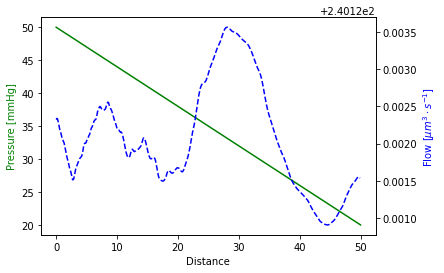

In [196]:
fig, ax = plt.subplots()
axFlow = ax.twinx()
ax.plot(locs, p, 'g-', label='Pressure')
axFlow.plot(locs[:-1], q, 'b--', label='Flow')
ax.set_xlabel('Distance')
ax.set_ylabel('Pressure [mmHg]', color='g')
axFlow.set_ylabel(r'Flow [$\mu m^3\cdot s^{-1}$]', color='b')

### Labelling

In [197]:
# Create a mesh (for its functions)
from Mesh import UniformGrid
mesh = UniformGrid(dimensions=np.array([locs[-1], 4*Radius, 4*Radius]), nCells=[n, 30, 30], units=L)
dx,dy,dz = mesh.spacing


        Mesh:
            Length scale: um
            Dimensions: [50. 20. 20.]
            Origin: [0. 0. 0.]
            Number of cells: [500  30  30]
            Spacing: [0.1        0.66666667 0.66666667]
            Total number of cells: 450000
            


In [198]:
nx.set_edge_attributes(G, False, name='VesselToVoxel')
nVascularVoxels = 0
VesselToVoxels = {}
vascularVoxels = []
for n1,n2,edge in tqdm(G.edges(data=True)):
    p1,p2 = G.nodes[n1]['position'], G.nodes[n2]['position']
    r,l = edge['radius'], np.linalg.norm(p1-p2)
    v = (p1-p2)/l
    P = np.outer(v, v)
    O = np.identity(3)-P
    p1, p2 = p1 - r*v, p2 + r*v
    cellMin, cellMax = mesh._BoundingBoxOfVessel(p1, p2, r) # Bounding box of vessel in the 1x1x1 cube
## TODO: Possible speed-up using einstein notation (np.einsum) or broadcast?
    for cellId in ((x,y,z) for x in range(cellMin[0], cellMax[0]+1)
                            for y in range(cellMin[1], cellMax[1]+1)
                            for z in range(cellMin[2], cellMax[2]+1)):
        try:
            cellCenter = mesh.CellCenter(cellId)
        except ValueError:
            hasUpdated, newLabel = False,0
            continue
        hasUpdated = False
        d = np.linalg.norm(O.dot(p1-cellCenter))
        if d < r-w/2.0:
            if mesh.labels.readValue(cellId)!=1:
                hasUpdated, newLabel = True, 1 # Vessel
                flatId = mesh.ToFlatIndexFrom3D(cellId)
                VesselToVoxels[(n2, flatId)] = 1
                mesh.labels.addValue(cellId, 1)
                nVascularVoxels+=1
                vascularVoxels.append(flatId)
        elif r-w/2.0<d<r+w/2.0:
            if 2!=mesh.labels.readValue(cellId)!=1:
                mesh.labels.addValue(cellId, 2)
                hasUpdated, newLabel = True, 2 # Endothelium
                VesselToVoxels[(n2, mesh.ToFlatIndexFrom3D(cellId))] = 0        

        if hasUpdated:
            mesh.labels.addValue(cellId, newLabel)


100%|██████████| 500/500 [01:17<00:00,  6.45it/s]


### The matrices mapping endothelial cells to vascular nodes 

In [199]:
K = np.array([[idx, node] for (node, idx), t in VesselToVoxels.items() if t!=1])
K = K[K[:,1].argsort()]

# WRONG
#  C2t = sp.coo_matrix((np.ones(K.shape[0]),(K[:,0],K[:,1])), 
#                      shape=(K.shape[0], mesh.nCellsTotal)).tocsr()
C2t = sp.eye(mesh.nCellsTotal, format='csr')[K[:,0]] # Identity without non-endothelial rows
C2v = sp.coo_matrix((np.ones(K.shape[0]),(K[:,0],K[:,1])), 
                     shape=(mesh.nCellsTotal, G.number_of_nodes())).tocsr()[K[:,0]]
# S = pylops.Diagonal(2*np.pi*Radius*dx*np.ones(locs.size)) # Surface area of each vessel
S = sp.eye(locs.size)*2*np.pi*Radius*dx
S = 2*np.pi*Radius*dx
del K

### The convection matrices

In [200]:
data, i, j = [], [], []
cvBar = np.zeros(G.number_of_nodes()) 
for n in (n for n in G.nodes if G.in_degree(n)==0):
    data.append(1)
    i.append(n)
    j.append(n)
    cvBar[n] = 50.0 # 50mmHg, inlet BC
for n1,n2,d in G.edges(data=True):
    c = d['flow']/(np.pi*(d['radius']**2)) # Flow velocity
    c/= np.linalg.norm(G.nodes[n1]['position']-G.nodes[n2]['position']) # Finite diff
    data.extend([c,-c])
    i.extend([n2,n2])
    j.extend([n2,n1])

M = sp.coo_matrix((data, (i,j)), 
                  shape=(G.number_of_nodes(), G.number_of_nodes())).tocsr()

del data
del i 
del j

Exited with code 0


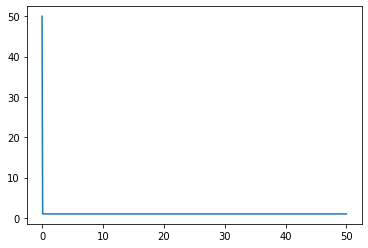

In [201]:
ct = np.ones(mesh.nCellsTotal)
# A = spl.LinearOperator(shape=M.shape, 
#                         matvec=lambda x: M*x + 1e-8*C2v.T.dot(C2v*x),
#                         rmatvec=lambda x: M.T*x + 1e-8*C2v.dot(C2v.T)*x)
cv = spl.spsolve_triangular(M + U*(np.pi*2*dx*Radius)*C2v.T*S*C2v, 
                       cvBar + U*(np.pi*2*dx*Radius)*C2v.T*S*C2t*ct)

print(f"Exited with code {code}")
_ = plt.plot(locs, cv) # Should be constant if the matrix is correct

### Diffusion operator

In [202]:
def Make1DDiffWithoutBC(nx, dx):
    M = sp.diags([D/dx/dx, -2*D/dx/dx, D/dx/dx], [-1, 0, 1], shape=(nx,nx), format='lil')
    M[0,1] = M[-1,-2] = 2*D/dx/dx
    return M

def Make3DWithNeumannBC(n, h):
    nx,ny,nz = n
    dx,dy,dz = h
    Dx, Dy, Dz = Make1DDiffWithoutBC(nx,dx), Make1DDiffWithoutBC(ny,dy), Make1DDiffWithoutBC(nz,dz)
    return -sp.kron(Dx, sp.eye(ny*nz)) + sp.kron(sp.eye(nx), sp.kron(Dy, sp.eye(nz))) + sp.kron(sp.eye(nx*ny), Dz)            

Diff = Make3DWithNeumannBC(mesh.nCells, mesh.spacing)

In [203]:
tmp = np.ones(mesh.nCellsTotal)
tmp[vascularVoxels] = 0
tmpI = sp.diags([tmp],[0])
# Diff = tmpI*Diff*tmpI
# Diff[vascularVoxels, vascularVoxels] = 1.0
del tmp
del tmpI

### Create LinearOperators for the Schur complement problem

In [204]:
G = pylops.LinearOperator(spl.LinearOperator(shape=(mesh.nCellsTotal, locs.size), 
                        matvec=lambda x:-U/w*C2t.T*(C2v*x)))
V = np.prod(mesh.spacing)
B = pylops.LinearOperator(spl.LinearOperator(shape=Diff.shape, 
            matvec=lambda x:Diff*x + kt*V*x + U/w*C2t.T*(C2t*x)))
E = pylops.LinearOperator(spl.LinearOperator(shape=(locs.size, mesh.nCellsTotal), 
            matvec=lambda x:-U/w*C2v.T*(C2t*x)))
A = M + U/w*C2v.T*C2v
Am = pylops.LinearOperator(spl.LinearOperator(shape=(locs.size, locs.size), 
            matvec=lambda x:spl.spsolve_triangular(A,x))) # This is equivalent to 
                                                          # multiplication by A-1

Sc = pylops.LinearOperator(spl.LinearOperator(shape=Diff.shape,
            matvec=lambda x:B*x-G*(Am*(E*x))))                

### Define the new rhs

In [205]:
bc = bc - G*(Am*cvBar) # replace first term by appropriate BC for non homogeneous Neumann

In [207]:
P = pylops.Diagonal(((2*D/dx/dx+2*D/dy/dy+2*D/dz/dz)**-1)*np.ones(Sc.shape[0])) # Preconditionner
y, code = spl.gmres(Sc, bc, callback=gmres_counter(), M=P)
print(code, np.linalg.norm(Sc*y-bc))

iter 100	rk = 5.672445290987625e-07
iter 200	rk = 5.165994568220836e-07
iter 300	rk = 4.907428001281526e-07
iter 400	rk = 4.735745137706114e-07
iter 500	rk = 4.607570788814181e-07
iter 600	rk = 4.505682982698619e-07
iter 700	rk = 4.421420796859535e-07
iter 800	rk = 4.349759410449611e-07
iter 900	rk = 4.2876006245594444e-07
iter 1000	rk = 4.2327633219877036e-07
iter 1100	rk = 4.183799155348801e-07
iter 1200	rk = 4.139540018755933e-07
iter 1300	rk = 4.0991862525302213e-07
iter 1400	rk = 4.0620020104673246e-07
iter 1500	rk = 4.0274693384516516e-07
iter 1600	rk = 3.9950036081326696e-07
iter 1700	rk = 3.964143434148359e-07
iter 1800	rk = 3.934118219960506e-07
iter 1900	rk = 3.90412334940368e-07
iter 2000	rk = 3.872384960377832e-07
iter 2100	rk = 3.8360418137220014e-07
iter 2200	rk = 3.7943179386492625e-07
iter 2300	rk = 3.761691440376599e-07
iter 2400	rk = 3.7404465917674586e-07
iter 2500	rk = 3.719391778588627e-07
iter 2600	rk = 3.6948394450954666e-07
iter 2700	rk = 3.6627746004532645e-07


In [ ]:
def ToVTK(mesh, VTKFileName : str, X : np.ndarray):
    """
    Saves the oxygen array X (1D) to VTKFileName in
    VTK_STRUCTURED_POINTS format.
    """

    with open(VTKFileName, 'w') as f:
        print("Writing solution to", VTKFileName)

        f.write("# vtk DataFile Version 3.0\n")
        f.write("A mesh for the computation of oxygen perfusion.\n")
        # f.write("BINARY\n")
        f.write("ASCII\n")
        f.write("DATASET STRUCTURED_POINTS\n")
        f.write(f"DIMENSIONS {mesh.nCells[0]+1} {mesh.nCells[1]+1} {mesh.nCells[2]+1}\n")
        f.write(f"ORIGIN {mesh.origin[0]} {mesh.origin[1]} {mesh.origin[2]}\n")
        f.write(f"SPACING {mesh.spacing[0]} {mesh.spacing[1]} {mesh.spacing[2]}\n")
        
        # Writing the data
        f.write(f"CELL_DATA {mesh.nVol}\n")
        f.write(f"SCALARS labels int 1\n")
        f.write(f"LOOKUP_TABLE default")
        f.write("\n")
        f.write("\n".join(tqdm(mesh.labels, desc=f"Writing labels to {VTKFileName}", total=mesh.nVol)))

        f.write(f"SCALARS PO2 float 1\n")
        f.write(f"LOOKUP_TABLE default")
        f.write("\n")
        f.write("\n".join(tqdm((str(xi) for xi in X), desc=f"Writing PO2 to {VTKFileName}", total=mesh.nVol)))

    return   

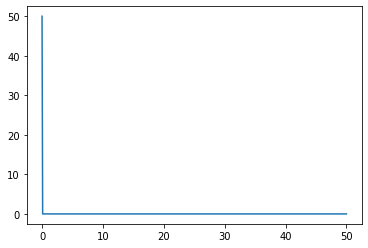

In [ ]:
cv = Am*(cvBar-E*y)
_ = plt.plot(locs, cv)
plt.show()

K = np.array([[idx, node] for (node, idx), t in VesselToVoxels.items() if t==1])
y[K[:,0]] = cv[K[:,1]]

In [ ]:
ToVTK(mesh, 'SingleVessel.vtk', y)

Writing labels to SingleVessel.vtk:  34%|███▍      | 154406/450000 [00:00<00:00, 1544054.11it/s]

Writing solution to SingleVessel.vtk


Writing PO2 to SingleVessel.vtk: 100%|██████████| 450000/450000 [00:00<00:00, 2399453.86it/s]
